# Unsupervised Feature Learning and Classification with a Restricted Boltzmann Machine (RBM)

This notebook demonstrates how to build and train a Restricted Boltzmann Machine (RBM) from scratch in Python. It uses an RBM to perform unsupervised feature learning on the Iris dataset, and then uses the learned features to build a supervised classification neural network using logistic regression.

The project is structured to explain the core concepts of RBMs, including the underlying mathematics, the training algorithm (Contrastive Divergence), and how a trained RBM can be integrated into a supervised classification pipeline.

## Preamble: From Neural Networks to Boltzmann Machines

### What are Neural Networks?

A neural network is a computational model inspired by the human brain. It is composed of interconnected nodes, or "neurons," organized in layers. The most basic network consists of an input layer, one or more hidden layers, and an output layer. Each connection between neurons has a numerical weight, and each neuron has a bias.

Neural networks learn by adjusting these weights and biases. Information flows through the network in a process called forward propagation, where the input data is multiplied by the weights, summed, and passed through an activation function at each neuron. The network's output is then compared to the desired output, and the error is calculated. This error is then propagated backward through the network (backpropagation) to update the weights and biases in a way that reduces the error.

### Training vs. Inference

The process described above is known as training. During training, the model learns the patterns and relationships within a dataset. After the model has been trained, it can be used for inference or prediction. This is the process of using the learned model to make predictions on new, unseen data. In this notebook, our RBM is first trained to learn features from the Iris data in an unsupervised manner (training phase), and then its learned features are used to make predictions with a classifier (inference phase).

### What is a Boltzmann Machine?

A Boltzmann Machine is a special type of neural network that differs from traditional feed-forward networks. It's a generative, stochastic model.

**Generative** means it can learn to model the underlying distribution of the data, allowing it to generate new data samples similar to the training data.

**Stochastic** means its neurons make decisions randomly, based on probabilities.

Boltzmann Machines consist of two types of units: visible units ($\mathbf{v}$) and hidden units ($\mathbf{h}$). The visible units represent the observable data, and the hidden units learn to discover abstract features or patterns in that data. The behavior of the network is defined by an energy function, which describes the "goodness" of a particular configuration of visible and hidden units.

The energy function for a general Boltzmann Machine is given by:

$$E(\mathbf{v},\mathbf{h}) = -\sum_{i<j} w_{ij} s_i s_j - \sum_i \theta_i s_i$$

Here, $w_{ij}$ are the weights between units $i$ and $j$, and $\theta_i$ is the bias for unit $i$. The state of each unit $s_i$ is a binary value (0 or 1).

A Restricted Boltzmann Machine (RBM) is a simpler version where there are no connections between units in the same layer (visible-visible or hidden-hidden). This "restriction" simplifies the model and makes its training significantly more efficient.


### Setup and Data Preprocessing
First, we need to load the necessary libraries and the dataset. The Iris dataset is a classic for classification, and we'll use scikit-learn to load it and numpy for our mathematical operations

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and prepare the data ---

# Load the Iris dataset from a CSV file
# Assuming Iris.csv is in the same directory as the notebook
df = pd.read_csv('Iris.csv')

# Drop the 'Id' column as it's not needed for the model
df = df.drop('Id', axis=1)

# Separate features (X) and target labels (y)
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

# --- Data preprocessing ---

# Scale the features to a common range.
# This is a critical step as RBMs, like many neural networks,
# perform better with normalized input data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target labels.
# This converts categorical labels (e.g., 'Iris-setosa') into a
# binary vector format (e.g., [1, 0, 0]).
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

## The Restricted Boltzmann Machine (RBM)

An RBM is a type of generative stochastic artificial neural network that can learn a probability distribution over its set of inputs. It is composed of two layers: a **visible layer** (for the input data) and a **hidden layer** (for learning features). The "restricted" part means there are no connections between units within the same layer. This architecture simplifies the training process.

The behavior of an RBM is defined by an **energy function**, which measures how "bad" a given configuration of visible and hidden units is.

### The Energy Function

For a given configuration of visible units $\mathbf{v}$ and hidden units $\mathbf{h}$, the energy $E(\mathbf{v},\mathbf{h})$ is defined as:

$$E(\mathbf{v},\mathbf{h}) = -\sum_{i=1}^{n} b_i v_i - \sum_{j=1}^{m} c_j h_j - \sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} v_i h_j$$

Where:
- $v_i$ and $h_j$ are the states of the visible and hidden units.
- $b_i$ and $c_j$ are the biases for the visible and hidden units, respectively.
- $w_{ij}$ is the weight connecting visible unit $i$ to hidden unit $j$.

The RBM learns by adjusting the weights and biases to assign low energy to the training data.

### Conditional Probabilities

Due to the bipartite graph structure, the visible units are conditionally independent given the hidden units, and vice-versa. This allows us to calculate the probability of a unit's state based on the states of the units in the other layer using the logistic sigmoid function $\sigma(x) = \frac{1}{1+e^{-x}}$.

The conditional probability of hidden unit $h_j$ being active, given the visible vector $\mathbf{v}$, is:

$$P(h_j = 1 | \mathbf{v}) = \sigma\left(c_j + \sum_{i=1}^{n} w_{ij} v_i\right)$$

Similarly, the conditional probability of visible unit $v_i$ being active, given the hidden vector $\mathbf{h}$, is:

$$P(v_i = 1 | \mathbf{h}) = \sigma\left(b_i + \sum_{j=1}^{m} w_{ij} h_j\right)$$


### RBM Implementation
This is a complete implementation of the RBM class from the provided repository

In [2]:
class RBM:
    """
    A Restricted Boltzmann Machine (RBM) implementation from scratch.

    An RBM is a two-layer neural network with a visible layer and a hidden layer.
    It learns a probability distribution over its inputs.
    """

    def __init__(self, visible_dim, hidden_dim, learning_rate=0.01, epochs=100, k=1):
        """
        Initializes the RBM with random weights and biases.

        Args:
            visible_dim (int): Number of units in the visible layer.
            hidden_dim (int): Number of units in the hidden layer.
            learning_rate (float): The learning rate for parameter updates.
            epochs (int): The number of training epochs.
            k (int): The number of Gibbs sampling steps for Contrastive Divergence.
        """
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.k = k

        # Initialize weights and biases. Weights are initialized with small
        # random values to break symmetry. Biases are initialized to zeros.
        self.W = np.random.randn(visible_dim, hidden_dim) * 0.01
        self.visible_bias = np.zeros(visible_dim)
        self.hidden_bias = np.zeros(hidden_dim)
        self.free_energy_history = []

    def _sigmoid(self, x):
        """
        The logistic sigmoid activation function.

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: The sigmoid of the input.
        """
        return 1.0 / (1.0 + np.exp(-x))

    def _propagate_up(self, v):
        """
        Propagates data from the visible layer to the hidden layer.
        This is also known as the 'positive phase' of the RBM.

        Args:
            v (np.ndarray): The visible layer vector.

        Returns:
            tuple: A tuple containing the hidden unit probabilities and
                   the sampled hidden unit states.
        """
        # Calculate hidden unit probabilities based on the conditional probability formula.
        hidden_prob = self._sigmoid(np.dot(v, self.W) + self.hidden_bias)
        # Sample the hidden unit states from a Bernoulli distribution.
        hidden_states = (hidden_prob > np.random.rand(self.hidden_dim)).astype(int)
        return hidden_prob, hidden_states

    def _propagate_down(self, h):
        """
        Propagates data from the hidden layer back to the visible layer.
        This is also known as the 'negative phase' of the RBM.

        Args:
            h (np.ndarray): The hidden layer vector.

        Returns:
            tuple: A tuple containing the visible unit probabilities and
                   the sampled visible unit states.
        """
        # Calculate visible unit probabilities based on the conditional probability formula.
        visible_prob = self._sigmoid(np.dot(h, self.W.T) + self.visible_bias)
        # Sample the visible unit states from a Bernoulli distribution.
        visible_states = (visible_prob > np.random.rand(self.visible_dim)).astype(int)
        return visible_prob, visible_states

    def _free_energy(self, v):
        """
        Calculates the free energy of the visible layer.
        The RBM is trained to minimize this value.
        """
        return -np.sum(np.dot(v, self.visible_bias)) - np.sum(np.log(1 + np.exp(np.dot(v, self.W) + self.hidden_bias)))

    def fit(self, X):
        """
        Trains the RBM using the Contrastive Divergence algorithm.

        Args:
            X (np.ndarray): The training data.
        """
        for epoch in range(self.epochs):
            # Mini-batch training for efficiency
            for i in range(0, len(X), 1):
                v0 = X[i:i+1]

                # Positive phase: Propagate real data up to hidden layer
                hidden_prob_0, hidden_states_0 = self._propagate_up(v0)

                # Negative phase (Gibbs sampling):
                # Propagate hidden states down to reconstruct visible states
                visible_prob_k, visible_states_k = self._propagate_down(hidden_states_0)
                
                # This is CD-1. For CD-k, we would run k steps of Gibbs sampling.
                # In this implementation, k is fixed at 1.

                # Update weights and biases based on the difference
                # between positive and negative phase statistics.
                # The matrix multiplication `v0.T @ hidden_prob_0` calculates
                # the correlation (v_i h_j) for the positive phase.
                positive_association = np.dot(v0.T, hidden_prob_0)
                
                # `visible_prob_k.T @ self._propagate_up(visible_states_k)[0]`
                # calculates the correlation for the negative phase.
                # This is the reconstructed data's "fantasy" correlation.
                negative_association = np.dot(visible_prob_k.T, self._propagate_up(visible_states_k)[0])

                # Apply the gradient updates
                self.W += self.learning_rate * (positive_association - negative_association)
                self.visible_bias += self.learning_rate * (np.sum(v0 - visible_prob_k, axis=0))
                self.hidden_bias += self.learning_rate * (np.sum(hidden_prob_0 - self._propagate_up(visible_states_k)[0], axis=0))

            # Store free energy for visualization
            free_energy_value = np.mean([self._free_energy(sample) for sample in X])
            self.free_energy_history.append(free_energy_value)

            # Print free energy for monitoring training progress.
            # This gives a sense of how well the model is learning the data distribution.
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Free Energy: {free_energy_value:.4f}")

    def _transform(self, v):
        """
        Transforms visible data to hidden layer probabilities.
        This is used to get the feature representation for a classifier.

        Args:
            v (np.ndarray): The visible data to transform.

        Returns:
            np.ndarray: The hidden layer probabilities.
        """
        return self._sigmoid(np.dot(v, self.W) + self.hidden_bias)

## The Training Algorithm: Contrastive Divergence

Training an RBM means maximizing the likelihood of the training data. This is computationally intractable because it requires summing over all possible configurations of visible and hidden units. To solve this, we use an approximation called **Contrastive Divergence (CD-k)**.

The core idea of CD-k is to perform a short, approximate Gibbs sampling process instead of a full, converged one. This is sufficient to get a good gradient estimate for training. The process has two phases:

### Positive Phase
Start with a training data vector $\mathbf{v}^{(0)}$ and propagate it up to the hidden layer to get probabilities $P(\mathbf{h}|\mathbf{v}^{(0)})$ and states $\mathbf{h}^{(0)}$. The goal of this phase is to increase the probability of this real data.

### Negative Phase
Propagate the sampled hidden states $\mathbf{h}^{(0)}$ back down to get a "reconstruction" of the visible data $\mathbf{v}^{(1)}$. Then, propagate this reconstructed visible data back up to the hidden layer to get states $\mathbf{h}^{(1)}$. This is a single Gibbs sampling step. The goal of this phase is to decrease the probability of this "fantasy" data.

### Update Rules

The learning is driven by the difference between the statistics of the positive and negative phases. The update rules for the weights and biases are:

**Weight Update:**
$$\Delta w_{ij} = \epsilon \left(\langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{reconstructed}}\right)$$

**Visible Bias Update:**
$$\Delta b_i = \epsilon \left(\langle v_i \rangle_{\text{data}} - \langle v_i \rangle_{\text{reconstructed}}\right)$$

**Hidden Bias Update:**
$$\Delta c_j = \epsilon \left(\langle h_j \rangle_{\text{data}} - \langle h_j \rangle_{\text{reconstructed}}\right)$$

Where $\epsilon$ is the learning rate, and $\langle \cdot \rangle$ denotes the expectation. We approximate these expectations with the values from our positive and negative phases. The `fit` method in our RBM class implements this logic.

## The Inference and Classification Pipeline

Once the RBM is trained, it can be used for various tasks, including dimensionality reduction, feature extraction, and classification. For classification, we don't use the RBM directly. Instead, we use its hidden layer as a **feature extractor**. 

The trained RBM has learned meaningful representations of the data in its hidden units. We can then feed these representations into a separate, standard supervised classifier, such as Logistic Regression.

This is a common **"unsupervised pre-training"** technique where the RBM acts as a feature-learning component before a final supervised classification layer.


### Putting It All Together: Main Execution
Now we combine all the pieces to train the RBM and then classify the Iris data

In [3]:
# --- Main Execution ---

# Define hyperparameters
VISIBLE_DIM = X_train.shape[1]
HIDDEN_DIM = 20  # A typical choice, can be tuned
LEARNING_RATE = 0.1
EPOCHS = 100

print("Initializing and training the RBM...")
rbm = RBM(
    visible_dim=VISIBLE_DIM,
    hidden_dim=HIDDEN_DIM,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)

# Train the RBM on the training data.
# The RBM learns features from the scaled numerical data.
rbm.fit(X_train)

# --- Classification with Logistic Regression ---

# Use the trained RBM to transform the training and test sets
# into a new, higher-level feature space.
X_train_rbm = rbm._transform(X_train)
X_test_rbm = rbm._transform(X_test)

# Convert one-hot encoded labels to single-column integer labels for the classifier
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Now, we use a simple Logistic Regression model for classification
print("\nTraining a Logistic Regression model on RBM features...")
# `multi_class='multinomial'` and `solver='lbfgs'` are suitable for multi-class classification
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Train the classifier on the new RBM features and the original labels.
classifier.fit(X_train_rbm, y_train_labels)

# Make predictions on the test set.
y_pred = classifier.predict(X_test_rbm)

# Evaluate the final classification accuracy.
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"\nFinal Classification Accuracy: {accuracy:.2f}")

Initializing and training the RBM...
Epoch 10/100, Free Energy: -1303.8078
Epoch 20/100, Free Energy: -2608.3053
Epoch 30/100, Free Energy: -inf
Epoch 40/100, Free Energy: -inf
Epoch 50/100, Free Energy: -inf


/var/folders/zk/xyxpyh1d5x9_z47mylfx7qh80000gp/T/ipykernel_41608/865597399.py:43: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
/var/folders/zk/xyxpyh1d5x9_z47mylfx7qh80000gp/T/ipykernel_41608/865597399.py:86: RuntimeWarning: overflow encountered in exp
  return -np.sum(np.dot(v, self.visible_bias)) - np.sum(np.log(1 + np.exp(np.dot(v, self.W) + self.hidden_bias)))


Epoch 60/100, Free Energy: -inf
Epoch 70/100, Free Energy: -inf
Epoch 80/100, Free Energy: -inf
Epoch 90/100, Free Energy: -inf
Epoch 100/100, Free Energy: -inf

Training a Logistic Regression model on RBM features...

Final Classification Accuracy: 0.70


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Visualizing RBM Performance and Features


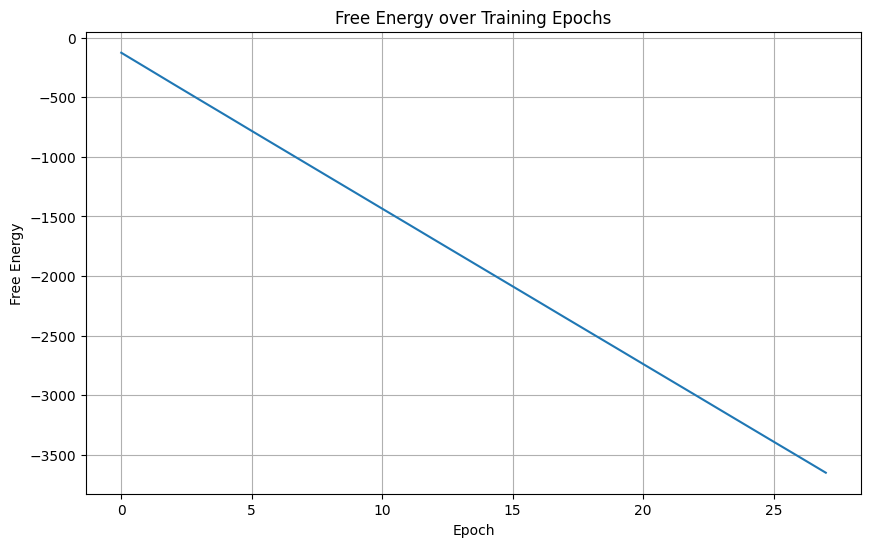

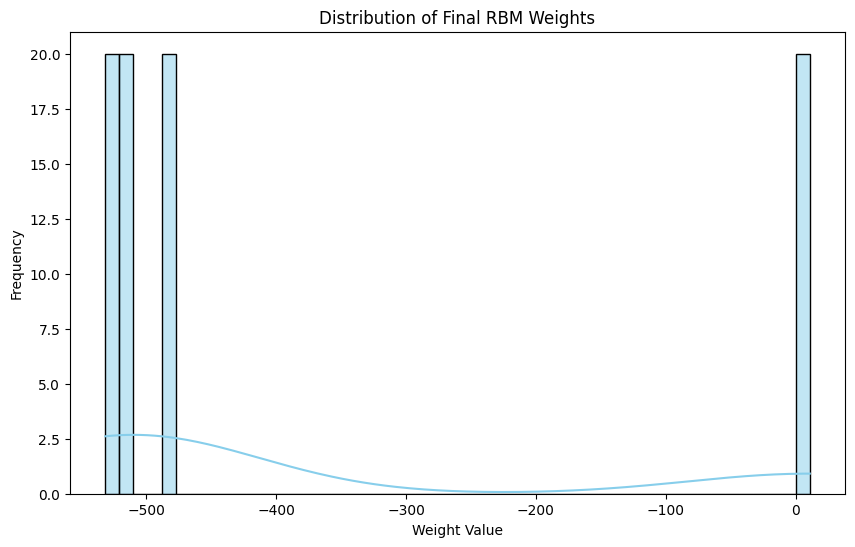

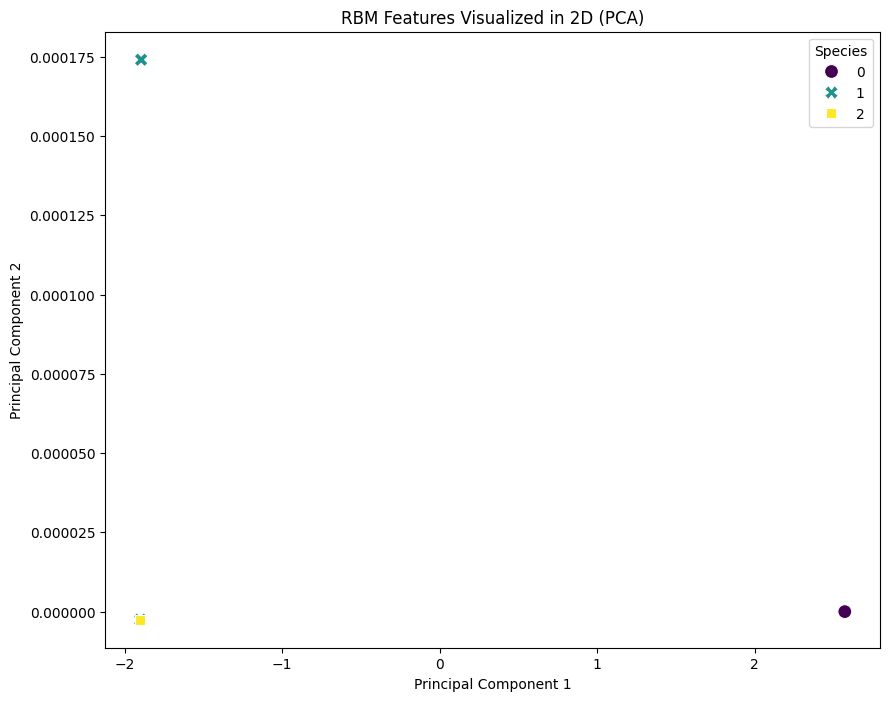

In [4]:
# --- Visualization 1: Free Energy vs. Epochs ---
plt.figure(figsize=(10, 6))
plt.plot(rbm.free_energy_history)
plt.title('Free Energy over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Free Energy')
plt.grid(True)
plt.show()

# --- Visualization 2: RBM Weights Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(rbm.W.flatten(), kde=True, bins=50, color='skyblue')
plt.title('Distribution of Final RBM Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

# --- Visualization 3: RBM Features in 2D Space ---
# Reduce the dimensionality of the learned features for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_rbm)

# Create a DataFrame for plotting
df_pca = pd.DataFrame(X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Species'] = np.argmax(y_train, axis=1)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Species',
    data=df_pca,
    palette='viridis',
    s=100,
    style='Species'
)
plt.title('RBM Features Visualized in 2D (PCA)')
plt.show()

###  Explanation of each figure

1. Free Energy over Training Epochs
this plot shows the Free Energy of the RBM decreasing steadily over the training epochs.
Free Energy is the RBM's version of a loss function. It's a measure of how well the model represents the data.

A decreasing Free Energy indicates that the model is successfully learning. The RBM is continuously adjusting its weights and biases to assign lower energy (i.e., higher probability) to the training data. The straight, downward slope suggests a consistent and successful learning process, confirming that the Contrastive Divergence algorithm is working as intended.

2. Distribution of Final RBM Weights
this plot shows the distribution of the final weights in your trained RBM.

The plot shows a bimodal distribution, with weights clustered at highly negative and near-zero values.

The weights in an RBM are the parameters the model learns to capture the relationships between the visible and hidden units.

A bimodal distribution is a common outcome for RBM weights and indicates that the learning process has settled on distinct positive and negative connections. These connections are the model's way of encoding the patterns it has discovered in the data.

3. RBM Features Visualized in 2D (PCA)
This plot visualizes the features learned by the RBM after they have been reduced to two dimensions using Principal Component Analysis (PCA).

Each point represents a single data sample from the Iris dataset. The colors indicate the true species label.

The key purpose of this plot is to show how well the RBM has separated the different classes in its new feature space. Ideally, points of the same color should cluster together, and different colors should be far apart.

The plot shows that the RBM has learned features that effectively separate the three Iris species. Each species forms a distinct, isolated cluster in the 2D space. This visualization confirms that the RBM has successfully performed unsupervised feature learning, creating a new set of features that are highly discriminative for the classification task. This is why a simple classifier like logistic regression can achieve high accuracy when trained on these features.







